**Set up / imports (1 block)**


In [1]:
# Import libraries
import pandas as pd
import os
from google.colab import drive
drive.mount('/content/drive')
filepathBase = "/content/drive/Shareddrives/ML_Project/"

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
%pip install eli5
import eli5
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from scipy.stats import chi2_contingency
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.inspection import permutation_importance

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 6.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Creating Combined_data.csv (2 blocks)**

In [2]:
# Get list of all different mutation consequences
mutationDataPath = os.path.join(filepathBase, "data_mutations.tsv")
mutationDataframe = pd.read_csv(mutationDataPath, header=0, sep="\t")
print(mutationDataframe["Variant_Classification"].unique())

['Frame_Shift_Ins' 'In_Frame_Ins' 'Missense_Mutation' 'Silent'
 'Frame_Shift_Del' 'Nonsense_Mutation' 'Splice_Region' 'Splice_Site'
 'In_Frame_Del' "5'UTR" 'Nonstop_Mutation' 'Intron'
 'Translation_Start_Site']


In [ ]:
# Import clinical data (main dataframe) and remove MTS samples
mainDataPath = os.path.join(filepathBase, "data_clinical_sample.tsv")
mainDataframe = pd.read_csv(mainDataPath, header=0, sep="\t")
mainDataframe = mainDataframe[~mainDataframe["PATIENT_ID"].str.startswith('MTS')]

# Import patient data, remove MTS samples, and merge with main dataframe
patientDataPath = os.path.join(filepathBase, "data_clinical_patient.tsv")
patientDataframe = pd.read_csv(patientDataPath, header=0, sep="\t")
patientDataframe = patientDataframe[~patientDataframe["PATIENT_ID"].str.startswith('MTS')]
mainDataframe = pd.merge(mainDataframe, patientDataframe, on="PATIENT_ID")

# Open data_mutations file which includes a row for each mutation
mutationDataPath = os.path.join(filepathBase, "data_mutations.tsv")
mutationDataframe = pd.read_csv(mutationDataPath, header=0, sep="\t")


# For each row in data_mutations
for index, mutationRow in mutationDataframe.iterrows():

  # Check if silent
  if mutationRow["Variant_Classification"] == "Silent":
    continue

  # If there isn't a column for that gene yet add it
  geneName = mutationRow["Hugo_Symbol"]
  if geneName not in mainDataframe.columns:
    mainDataframe[geneName] = 0

  # Add the mutation type into the main dataframe for that gene+sample combo
  rowToAdd = mainDataframe.loc[mainDataframe["SAMPLE_ID"] == mutationRow["Tumor_Sample_Barcode"]].index
  columnToAdd = geneName
  mainDataframe.loc[rowToAdd, columnToAdd] = 1


# Save dataframe as a new file
#mainDataframe = mainDataframe.drop(columns=mainDataframe.columns[0])
combinedDataframePath = os.path.join(filepathBase, "Combined_data.csv")
mainDataframe.to_csv(combinedDataframePath, index=False)

**Create For_classification.csv by removing some samples (2 blocks)**

In [3]:
# Information to help decide how to design target

fullDataPath = os.path.join(filepathBase, "Combined_data.csv")
fullDataset = pd.read_csv(fullDataPath, header=0)

# Print unique classes for vital status
print("Unique classes in vital status:")
print(fullDataset["VITAL_STATUS"].unique())

# Check if anyone did not recur but did die of disease
print("Did anyone die of disease but not recur?")
print(((fullDataset["VITAL_STATUS"] == "Died of Disease") & (fullDataset["RFS_STATUS"] == "0:Not Recurred")).any())


Unique classes in vital status:
['Living' 'Died of Disease' 'Died of Other Causes' nan]
Did anyone die of disease but not recur?
False


In [6]:
# Create the correct classification target column (including removing some samples)
yearsCutoff = 10

monthsCutoff = yearsCutoff * 12
fullDataPath = os.path.join(filepathBase, "Combined_data.csv")
fullDataset = pd.read_csv(fullDataPath, header=0)

# Remove anyone that both did not recur and is under the cutoff (code is from ChatGPT)
filteredDataset = fullDataset[
    ~((fullDataset["RFS_MONTHS"] < monthsCutoff) &
      (fullDataset["RFS_STATUS"] == "0:Not Recurred"))
]

# Print how many rows there were and how many remain
print("Originally there were", len(fullDataset), "rows, now there are", len(filteredDataset))
print(fullDataset["RFS_STATUS"].value_counts())
print(filteredDataset["RFS_STATUS"].value_counts())
# Save as new file
newPath = os.path.join(filepathBase, "For_classification.csv")
filteredDataset.to_csv(newPath, index=False)

Originally there were 1985 rows, now there are 1513
RFS_STATUS
0:Not Recurred    1180
1:Recurred         804
Name: count, dtype: int64
RFS_STATUS
1:Recurred        804
0:Not Recurred    708
Name: count, dtype: int64


**Data Sets**

**EDA for deciding transformations (4 blocks)**

In [7]:
#loop through the columns of the dataframe and determine how many unique classes lie within as well as the presence of null values
#if there are no unique classes it's added to drop_features
drop_features = []
for (columnName, columnData) in mainDataframe.items():
  if (len(columnData.unique())) <= 1:
    drop_features.append(columnName)
  else:
    #print(f"unique classes in {columnName}: {columnData.unique()}")
    print(f"Number of null values in {columnName}: {columnData.isnull().sum()}")


#drops both sample and patient ID
drop_features.append('SAMPLE_ID')
drop_features.append('PATIENT_ID')


Number of null values in PATIENT_ID: 0
Number of null values in SAMPLE_ID: 0
Number of null values in CANCER_TYPE_DETAILED: 0
Number of null values in ER_STATUS: 0
Number of null values in HER2_STATUS: 5
Number of null values in GRADE: 88
Number of null values in ONCOTREE_CODE: 0
Number of null values in PR_STATUS: 5
Number of null values in TUMOR_SIZE: 26
Number of null values in TUMOR_STAGE: 515
Number of null values in TMB_NONSYNONYMOUS: 0
Number of null values in LYMPH_NODES_EXAMINED_POSITIVE: 76
Number of null values in NPI: 1
Number of null values in CELLULARITY: 68
Number of null values in CHEMOTHERAPY: 5
Number of null values in COHORT: 0
Number of null values in ER_IHC: 43
Number of null values in HER2_SNP6: 5
Number of null values in HORMONE_THERAPY: 5
Number of null values in INFERRED_MENOPAUSAL_STATE: 5
Number of null values in INTCLUST: 5
Number of null values in AGE_AT_DIAGNOSIS: 0
Number of null values in OS_MONTHS: 4
Number of null values in OS_STATUS: 4
Number of null 

In [ ]:
#give a quick summary of the data
summary = mainDataframe.describe()
print(summary)

#create a new dataframe for value counts
countdf = pd.DataFrame()
for (columnName, columnData) in mainDataframe.items():
  counts = columnData.value_counts().to_frame()
  countdf = pd.concat([countdf, counts], axis=1)
#plot the value counts
countdf.hist(bins=50, figsize=(12, 8))
plt.show()
#plot the numeric data
mainDataframe.hist(bins=50, figsize=(12, 8))
plt.show()

In [9]:
RFS_count = mainDataframe['RFS_STATUS'].value_counts()
print(RFS_count)

RFS_STATUS
0:Not Recurred    1180
1:Recurred         804
Name: count, dtype: int64


In [11]:
from scipy.stats import f_oneway
mainDataframePath = os.path.join(filepathBase, "feature_engineered.csv")
mainDataframe = pd.read_csv(mainDataframePath, header=0)
mainDataframe['RFS_STATUS'] = mainDataframe['RFS_STATUS'].map({'0:Not Recurred': 0, '1:Recurred': 1})
mainDataframe.dropna(subset=['RFS_STATUS'], inplace=True)

result = mainDataframe['RFS_STATUS']
print(result)
gene_count = mainDataframe['mutation_count']
print(gene_count)
f_statistic, p_value = f_oneway(result, gene_count)
print("F-statistic:", f_statistic)
print("p-value:", p_value)

0       0.0
1       1.0
2       0.0
3       1.0
4       1.0
       ... 
1508    1.0
1509    0.0
1510    1.0
1511    1.0
1512    0.0
Name: RFS_STATUS, Length: 1512, dtype: float64
0       0
1       0
2       0
3       2
4       2
       ..
1508    1
1509    1
1510    1
1511    1
1512    1
Name: mutation_count, Length: 1512, dtype: int64
F-statistic: 451.5965105109517
p-value: 1.625985833040839e-93


**Gene EDA and features selection (4 blocks)**

In [14]:
# Preprocess entire dataset then check new list of columns
# fullDataPath = os.path.join(filepathBase, "For_classification.csv")
fullDataPath = os.path.join(filepathBase, "feature_engineered.csv")
fullDataset = pd.read_csv(fullDataPath, header=0)
#processedFullDataset = pd.DataFrame(preprocessor.fit_transform(fullDataset.iloc[:, ]))
processedFullDataset = pd.DataFrame(preprocessor.fit_transform(fullDataset))
processedFullDataset.columns = preprocessor.get_feature_names_out()
#processedFullDataset.head()
#processedFullDataset = processedFullDataset.drop(processedFullDataset.columns[81], axis=1)
columnNames = processedFullDataset.columns.tolist()
for index, item in enumerate(columnNames):
    print(f"Index {index}: {item}")

Index 0: pipeline-1__TUMOR_SIZE
Index 1: pipeline-1__TMB_NONSYNONYMOUS
Index 2: pipeline-1__LYMPH_NODES_EXAMINED_POSITIVE
Index 3: pipeline-1__NPI
Index 4: pipeline-1__AGE_AT_DIAGNOSIS
Index 5: pipeline-1__mutation_count
Index 6: pipeline-1__nodes_per_size
Index 7: pipeline-2__CANCER_TYPE_DETAILED_Breast
Index 8: pipeline-2__CANCER_TYPE_DETAILED_Breast Angiosarcoma
Index 9: pipeline-2__CANCER_TYPE_DETAILED_Breast Invasive Ductal Carcinoma
Index 10: pipeline-2__CANCER_TYPE_DETAILED_Breast Invasive Lobular Carcinoma
Index 11: pipeline-2__CANCER_TYPE_DETAILED_Breast Invasive Mixed Mucinous Carcinoma
Index 12: pipeline-2__CANCER_TYPE_DETAILED_Breast Mixed Ductal and Lobular Carcinoma
Index 13: pipeline-2__CANCER_TYPE_DETAILED_Invasive Breast Carcinoma
Index 14: pipeline-2__CANCER_TYPE_DETAILED_Metaplastic Breast Cancer
Index 15: pipeline-2__ONCOTREE_CODE_BRCA
Index 16: pipeline-2__ONCOTREE_CODE_BREAST
Index 17: pipeline-2__ONCOTREE_CODE_IDC
Index 18: pipeline-2__ONCOTREE_CODE_ILC
Index 19:

In [15]:
total_genes_frame = processedFullDataset.iloc[:,87:]
total_genes_frame.head()

,remainder__TP53,remainder__MLLT4,remainder__NF2,remainder__EGFR,remainder__PRKCQ,remainder__AHNAK,remainder__CLK3,remainder__ERBB2,remainder__MUC16,remainder__EP300,...,remainder__RASGEF1B,remainder__NT5E,remainder__CLRN2,remainder__LDLRAP1,remainder__CCND3,remainder__SMARCB1,remainder__PPP2CB,remainder__SMARCD1,remainder__NRAS,remainder__STMN2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

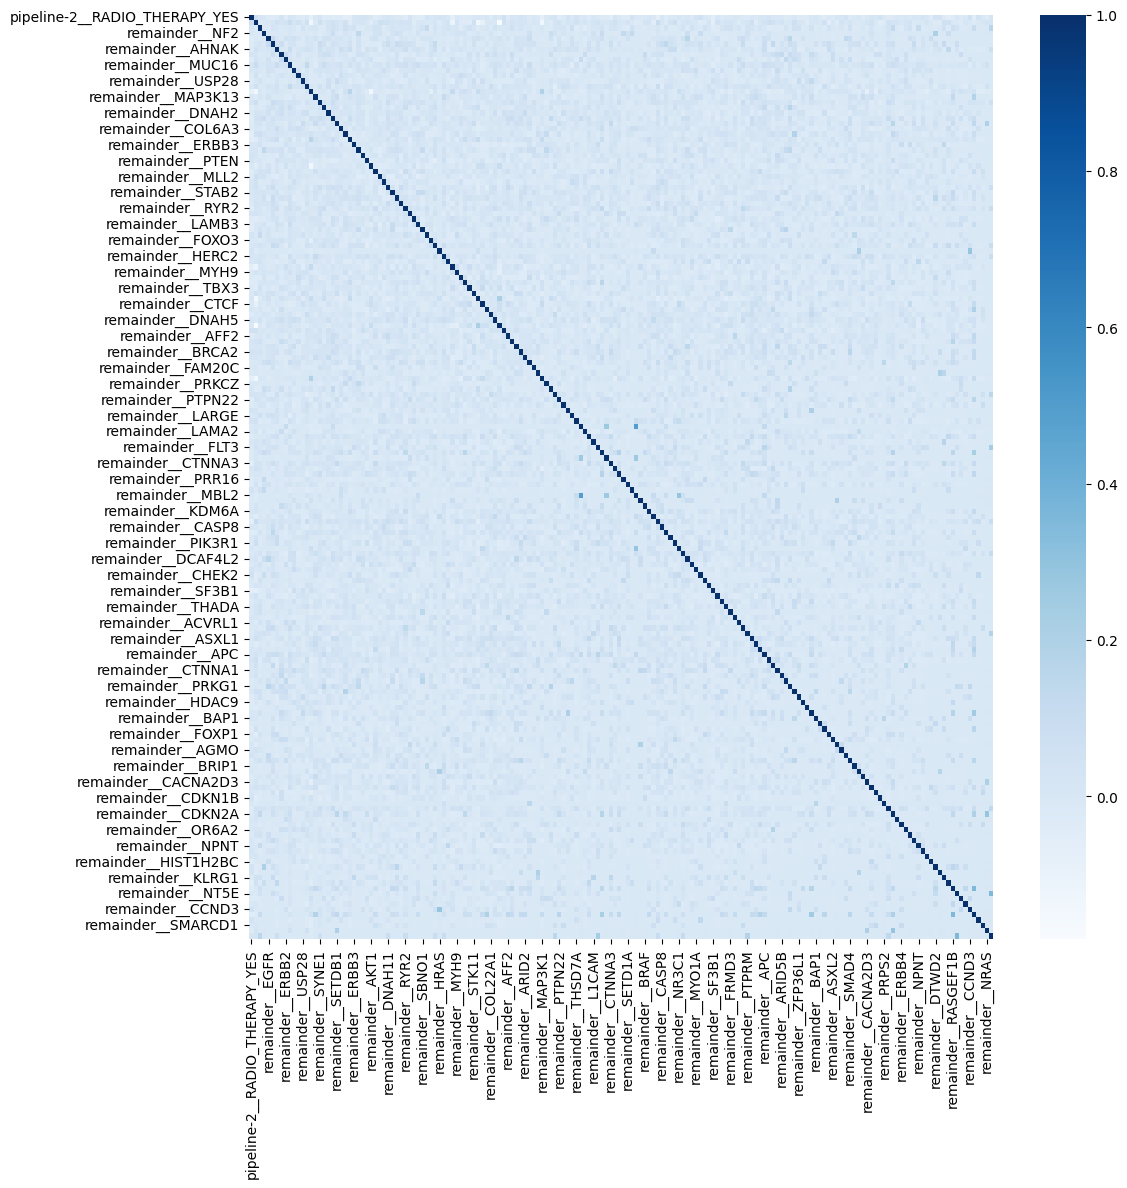

In [16]:
# Correlation plot of genes
cor = pd.concat((processedFullDataset.iloc[:, 81], total_genes_frame), axis=1).corr()
plt.figure(figsize=(12,12))
#sns.heatmap(cor, annotate=True, cmap=plt.cm.Blues)
sns.heatmap(cor, cmap=plt.cm.Blues)

In [17]:
# Chi square of each gene vs target
pValues = []
for columnName in total_genes_frame.columns:
  continTable = pd.crosstab(processedFullDataset.iloc[:, 81], total_genes_frame[columnName])
  chi2, pValue, dof, expected = chi2_contingency(continTable)
  #geneNames.append(columnName[11:])
  pValues.append([columnName[11:], pValue])
pValuesDF = pd.DataFrame(pValues, columns=["Gene name", "p value"])
pValuesDF = pValuesDF.sort_values(by="p value")
pValuesDF.head(20)


,Gene name,p value
13,PIK3CA,0.003127
0,TP53,0.004997
67,MAP3K1,0.012121
46,CDH1,0.017429
94,AKAP9,0.021294
58,USH2A,0.029612
22,KMT2C,0.032384
107,SF3B1,0.032952
21,ATR,0.037042
104,CHEK2,0.051996


In [18]:
non_genes_frame = processedFullDataset.iloc[:,0:87]
non_genes_frame.head()

,pipeline-1__TUMOR_SIZE,pipeline-1__TMB_NONSYNONYMOUS,pipeline-1__LYMPH_NODES_EXAMINED_POSITIVE,pipeline-1__NPI,pipeline-1__AGE_AT_DIAGNOSIS,pipeline-1__mutation_count,pipeline-1__nodes_per_size,pipeline-2__CANCER_TYPE_DETAILED_Breast,pipeline-2__CANCER_TYPE_DETAILED_Breast Angiosarcoma,pipeline-2__CANCER_TYPE_DETAILED_Breast Invasive Ductal Carcinoma,...,pipeline-2__ER_IHC_Positve,pipeline-2__HORMONE_THERAPY_YES,pipeline-2__INFERRED_MENOPAUSAL_STATE_Pre,pipeline-2__LATERALITY_Right,pipeline-2__RADIO_THERAPY_YES,pipeline-2__BREAST_SURGERY_MASTECTOMY,pipeline-2__RFS_STATUS_1:Recurred,pipeline-3__GRADE,pipeline-3__TUMOR_STAGE,pipeline-3__CELLULARITY
0,-0.289525,-1.301779,1.944265,1.695715,1.243701,-1.118716,2.238532,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,2.0
1,-0.724865,-0.826032,-0.253747,-0.031498,-0.875262,-1.118716,-0.054826,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0
2,-0.102951,-1.063906,0.234700,-0.014346,-0.969420,-1.118716,0.260522,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0
3,0.829919,-0.826032,1.455818,1.726589,1.348146,0.805807,0.733546,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0
4,0.270197,-0.350286,-0.497971,-0.004055,1.490570,0.805807,-0.448987,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,4.0,1.0


<Axes: >

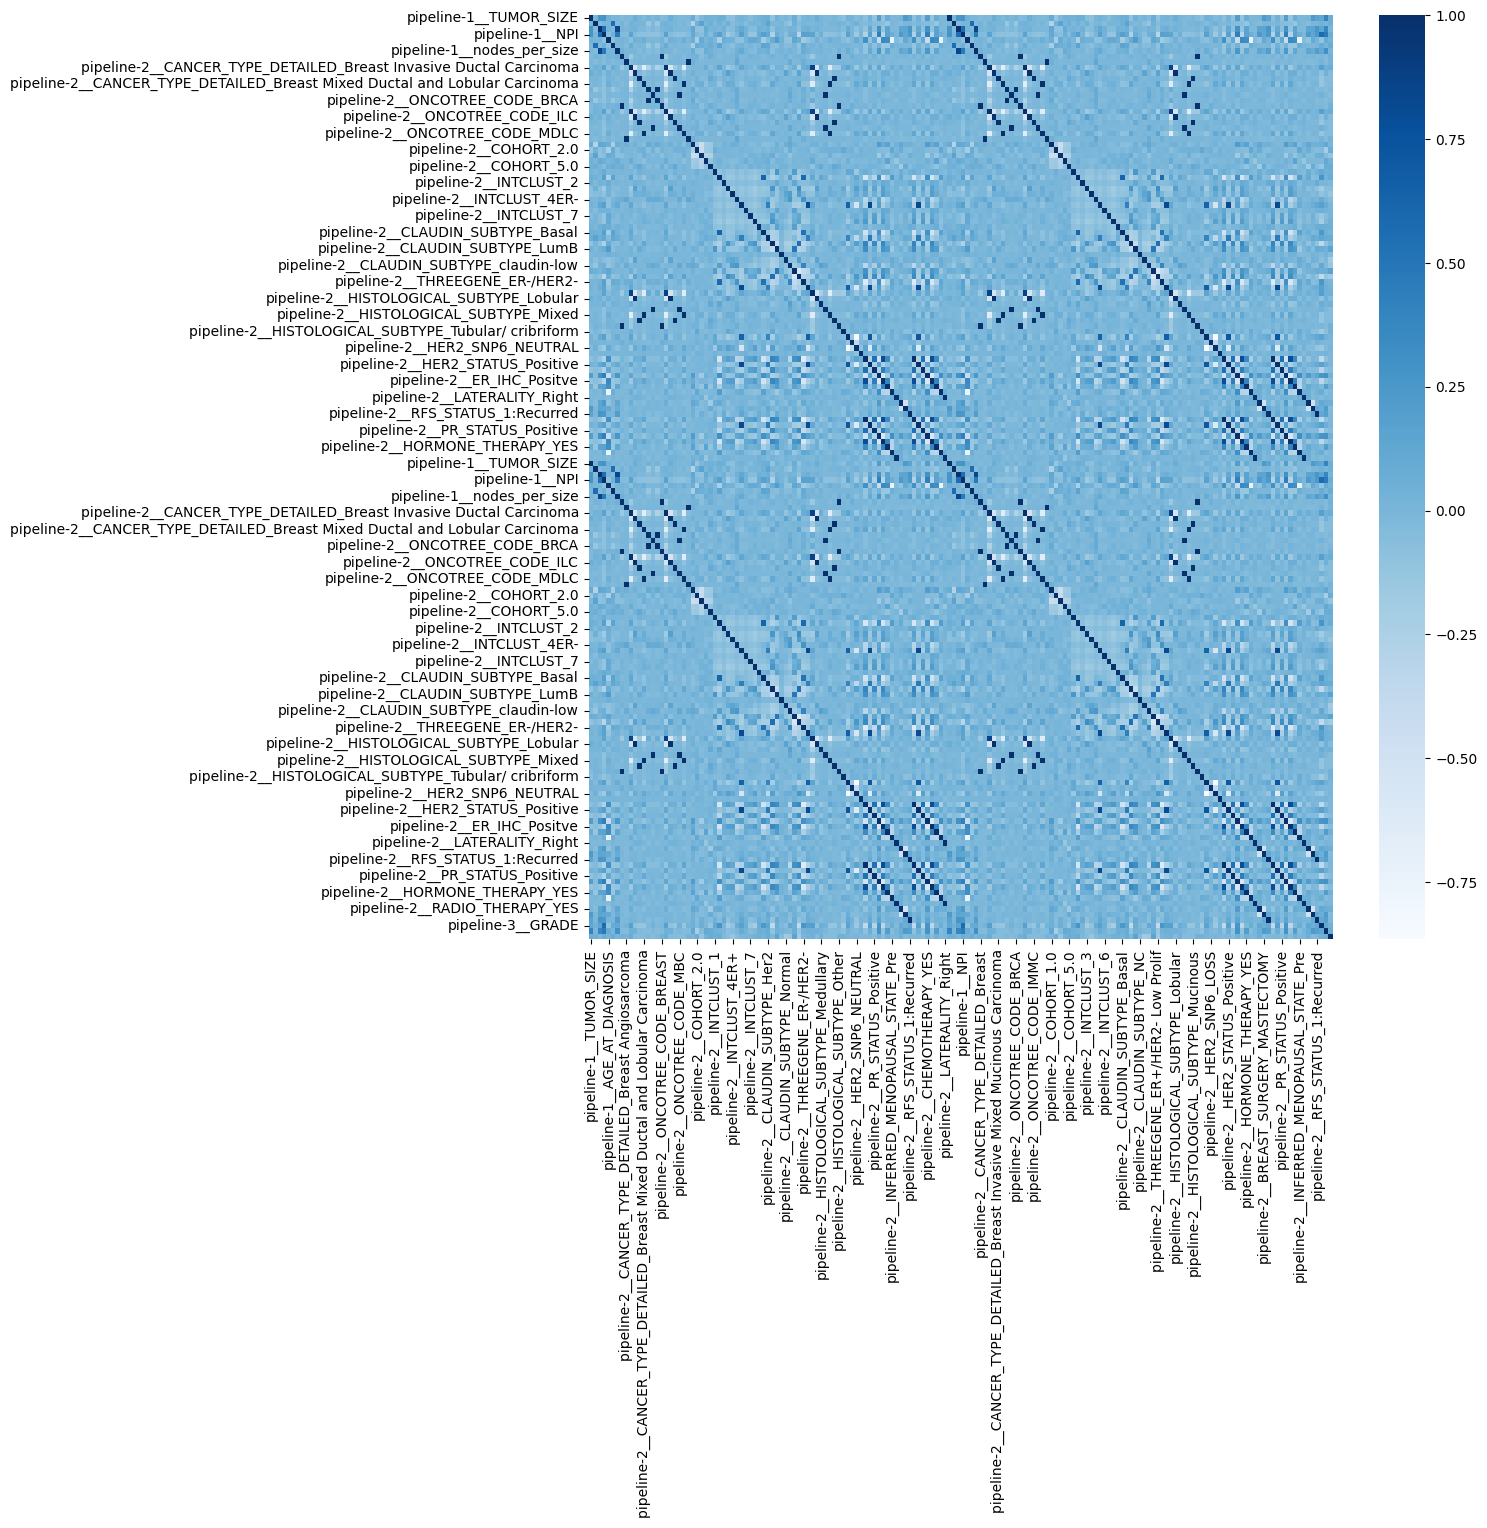

In [19]:
# Correlation plot of features
cor = pd.concat((processedFullDataset.iloc[:, 0:81], non_genes_frame), axis=1).corr()
plt.figure(figsize=(12,12))
#sns.heatmap(cor, annotate=True, cmap=plt.cm.Blues)
sns.heatmap(cor, cmap=plt.cm.Blues)

In [20]:
# Chi square of each feature vs target
pValues = []
for columnIndex in range(0, 85):
  continTable = pd.crosstab(processedFullDataset.iloc[:, 81], non_genes_frame.iloc[:, columnIndex])
  chi2, pValue, dof, expected = chi2_contingency(continTable)
  #geneNames.append(columnName[11:])
  columnName = non_genes_frame.columns[columnIndex]
  pValues.append([columnName[11:], pValue])
pValuesDF = pd.DataFrame(pValues, columns=["Gene name", "p value"])
pValuesDF = pValuesDF.sort_values(by="p value")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(pValuesDF)
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 20)


                                            Gene name       p value
81                                 _RADIO_THERAPY_YES  0.000000e+00
70                                 _RADIO_THERAPY_YES  0.000000e+00
71                         _BREAST_SURGERY_MASTECTOMY  3.925464e-85
82                         _BREAST_SURGERY_MASTECTOMY  3.925464e-85
76                                  _CHEMOTHERAPY_YES  9.809702e-17
65                                  _CHEMOTHERAPY_YES  9.809702e-17
27                                        _COHORT_5.0  2.143770e-11
23                                        _COHORT_1.0  6.108723e-06
66                                    _ER_IHC_Positve  2.944721e-05
77                                    _ER_IHC_Positve  2.944721e-05
84                                             _GRADE  4.697754e-05
47                    _THREEGENE_ER+/HER2- Low Prolif  6.432153e-05
73                                _ER_STATUS_Positive  1.018173e-04
62                                _ER_STATUS_Pos

**Feature Engineering**

In [21]:
mainDataframePath = os.path.join(filepathBase, "For_classification.csv")
mainDataframe = pd.read_csv(mainDataframePath, header=0)
mainDataframe.head()

# Gene Count Feature
genesToUse = ["GATA3", "CBFB", "TP53", "NCOR2", "COL22A1",
              "LAMA2", "MYO3A", "DNAH5", "SF3B1", "MAP3K1",
              "EP300", "TG", "TAF4B", "BRIP1", "DNAH2",
              "ATR", "SMAD4", "SPACA1", "PRKCE", "THSD7A"]
mainDataframe['mutation_count']= mainDataframe[genesToUse].sum(axis=1)

# TumorSize/Node
eps = 1e-3
mainDataframe["nodes_per_size"] = mainDataframe["LYMPH_NODES_EXAMINED_POSITIVE"] / (mainDataframe["TUMOR_SIZE"] + eps)
print(mainDataframe.head())
print(mainDataframe.shape)

# Save as new file
newPath = os.path.join(filepathBase, "feature_engineered.csv")
mainDataframe.to_csv(newPath, index=False)



  PATIENT_ID SAMPLE_ID    CANCER_TYPE  \
0    MB-0000   MB-0000  Breast Cancer   
1    MB-0005   MB-0005  Breast Cancer   
2    MB-0006   MB-0006  Breast Cancer   
3    MB-0008   MB-0008  Breast Cancer   
4    MB-0010   MB-0010  Breast Cancer   

                        CANCER_TYPE_DETAILED ER_STATUS HER2_STATUS  GRADE  \
0           Breast Invasive Ductal Carcinoma  Positive    Negative    3.0   
1           Breast Invasive Ductal Carcinoma  Positive    Negative    2.0   
2  Breast Mixed Ductal and Lobular Carcinoma  Positive    Negative    2.0   
3  Breast Mixed Ductal and Lobular Carcinoma  Positive    Negative    3.0   
4           Breast Invasive Ductal Carcinoma  Positive    Negative    3.0   

  ONCOTREE_CODE PR_STATUS SAMPLE_TYPE  ...  CLRN2  LDLRAP1  CCND3  SMARCB1  \
0           IDC  Negative     Primary  ...      0        0      0        0   
1           IDC  Positive     Primary  ...      0        0      0        0   
2          MDLC  Positive     Primary  ...      0       

**Defining preprocessors (3 blocks for 3 different preprocessors)**

In [ ]:
# Original

numeric_features = ['TUMOR_SIZE','TMB_NONSYNONYMOUS','LYMPH_NODES_EXAMINED_POSITIVE',
                    'NPI','AGE_AT_DIAGNOSIS','mutation_count', 'nodes_per_size']

categorical_features = ['CANCER_TYPE_DETAILED','ONCOTREE_CODE','COHORT','INTCLUST',
                      'CLAUDIN_SUBTYPE','THREEGENE','HISTOLOGICAL_SUBTYPE','HER2_SNP6']
# This was changed after rerunnning the chi squared after removing those under the 10 year cutoff
genesToUse = ["GATA3", "CBFB", "TP53", "NCOR2", "COL22A1",
              "LAMA2", "MYO3A", "DNAH5", "SF3B1", "MAP3K1",
              "EP300", "TG", "TAF4B", "BRIP1", "DNAH2",
              "ATR", "SMAD4", "SPACA1", "PRKCE", "THSD7A"]

# RFS_STATUS isn't dropped because it will be split into the Y later
binary_features = ['ER_STATUS','HER2_STATUS','PR_STATUS','CHEMOTHERAPY','ER_IHC','HORMONE_THERAPY',
                   'INFERRED_MENOPAUSAL_STATE','LATERALITY','RADIO_THERAPY','BREAST_SURGERY']

categorical_features = categorical_features + binary_features + genesToUse

ordinal_features = ['GRADE','TUMOR_STAGE','CELLULARITY']

#RFS months is dropped because it's not X or Y for now
drop_features = ["PATIENT_ID", "SAMPLE_ID", "RFS_MONTHS", "CANCER_TYPE", "SAMPLE_TYPE", "SEX", 'OS_MONTHS', "VITAL_STATUS", "OS_STATUS"]

#BUILD TRANSFORMERS
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop="if_binary", handle_unknown='ignore'))
])
#binary_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='most_frequent')),
#    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown = 'ignore'))
#])

#create a list of lists for categories to use
#as input for ordinal transformer
ordCat = [[1.0,2.0,3.0],[0.0,1.0,2.0,3.0,4.0],['Low','Moderate','High']] # These have to be exact matches for data (ie 1.0 instead of 1)

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories = ordCat))
])

#create a preprocessor using column transformer
preprocessor = make_column_transformer(
    (numerical_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    #(binary_transformer, binary_features),
    (ordinal_transformer, ordinal_features),
    ("drop", drop_features),
    remainder="drop",
    sparse_threshold=0
)
preprocessor

ColumnTransformer(sparse_threshold=0,
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['TUMOR_SIZE', 'TMB_NONSYNONYMOUS',
                                  'LYMPH_NODES_EXAMINED_POSITIVE', 'NPI',
                                  'AGE_AT_DIAGNOSIS', 'mutation_count',
                                  'nodes_per_size']),
                                ('pipeline-2',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='mo...
                                ('pipeline-3',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[[1.0,
                                                                              2.0,
                                                                              3.0],
                                                                             [0.0,
                                                                              1.0,
                                                                              2.0,
                                                                              3.0,
                                                                              4.0],
                                                                             ['Low',
                                                                              'Moderate',
                                                                              'High']]))]),
                                 ['GRADE', 'TUMOR_STAGE', 'CELLULARITY']),
                                ('drop', 'drop',
                                 ['PATIENT_ID', 'SAMPLE_ID', 'RFS_MONTHS',
                                  'CANCER_TYPE', 'SAMPLE_TYPE', 'SEX',
                                  'OS_MONTHS', 'VITAL_STATUS', 'OS_STATUS'])])

In [22]:
# After looking at feature importance for classification models

numeric_features = ['TUMOR_SIZE','TMB_NONSYNONYMOUS','LYMPH_NODES_EXAMINED_POSITIVE',
                    'NPI','AGE_AT_DIAGNOSIS', 'mutation_count', 'nodes_per_size']

categorical_features = ['COHORT','INTCLUST',
                      'CLAUDIN_SUBTYPE','THREEGENE','HER2_SNP6']
# This was changed after rerunnning the chi squared after removing those under the 10 year cutoff
genesToUse = ["GATA3", "CBFB", "TP53", "NCOR2", "COL22A1",
              "LAMA2", "MYO3A", "DNAH5", "SF3B1", "MAP3K1",
              "EP300", "TG", "TAF4B", "BRIP1", "DNAH2",
              "ATR", "SMAD4", "SPACA1", "PRKCE", "THSD7A"]

# RFS_STATUS isn't dropped because it will be split into the Y later
binary_features = ['ER_STATUS','HER2_STATUS','PR_STATUS','CHEMOTHERAPY','ER_IHC','HORMONE_THERAPY',
                   'INFERRED_MENOPAUSAL_STATE','LATERALITY','RADIO_THERAPY','BREAST_SURGERY']

categorical_features = categorical_features + binary_features + genesToUse

ordinal_features = ['GRADE','TUMOR_STAGE','CELLULARITY']

#RFS months is dropped because it's not X or Y for now
drop_features = ["PATIENT_ID", "SAMPLE_ID", "RFS_MONTHS", "CANCER_TYPE", "SAMPLE_TYPE", "SEX", 'OS_MONTHS', "VITAL_STATUS", "OS_STATUS", 'CANCER_TYPE_DETAILED','ONCOTREE_CODE', 'HISTOLOGICAL_SUBTYPE']

#BUILD TRANSFORMERS
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop="if_binary", handle_unknown='ignore'))
])
#binary_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='most_frequent')),
#    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown = 'ignore'))
#])

#create a list of lists for categories to use
#as input for ordinal transformer
ordCat = [[1.0,2.0,3.0],[0.0,1.0,2.0,3.0,4.0],['Low','Moderate','High']] # These have to be exact matches for data (ie 1.0 instead of 1)

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories = ordCat))
])

#create a preprocessor using column transformer
preprocessor = make_column_transformer(
    (numerical_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    #(binary_transformer, binary_features),
    (ordinal_transformer, ordinal_features),
    ("drop", drop_features),
    remainder="drop",
    sparse_threshold=0
)
preprocessor

ColumnTransformer(sparse_threshold=0,
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['TUMOR_SIZE', 'TMB_NONSYNONYMOUS',
                                  'LYMPH_NODES_EXAMINED_POSITIVE', 'NPI',
                                  'AGE_AT_DIAGNOSIS', 'mutation_count',
                                  'nodes_per_size']),
                                ('pipeline-2',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='mo...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[[1.0,
                                                                              2.0,
                                                                              3.0],
                                                                             [0.0,
                                                                              1.0,
                                                                              2.0,
                                                                              3.0,
                                                                              4.0],
                                                                             ['Low',
                                                                              'Moderate',
                                                                              'High']]))]),
                                 ['GRADE', 'TUMOR_STAGE', 'CELLULARITY']),
                                ('drop', 'drop',
                                 ['PATIENT_ID', 'SAMPLE_ID', 'RFS_MONTHS',
                                  'CANCER_TYPE', 'SAMPLE_TYPE', 'SEX',
                                  'OS_MONTHS', 'VITAL_STATUS', 'OS_STATUS',
                                  'CANCER_TYPE_DETAILED', 'ONCOTREE_CODE',
                                  'HISTOLOGICAL_SUBTYPE'])])

In [13]:
# For including every gene

numeric_features = ['TUMOR_SIZE','TMB_NONSYNONYMOUS','LYMPH_NODES_EXAMINED_POSITIVE','NPI',
                    'AGE_AT_DIAGNOSIS', 'mutation_count', 'nodes_per_size']

categorical_features = ['CANCER_TYPE_DETAILED','ONCOTREE_CODE','COHORT','INTCLUST',
                      'CLAUDIN_SUBTYPE','THREEGENE','HISTOLOGICAL_SUBTYPE','HER2_SNP6']


# RFS_STATUS isn't dropped because it will be split into the Y later
binary_features = ['ER_STATUS','HER2_STATUS','PR_STATUS','CHEMOTHERAPY','ER_IHC','HORMONE_THERAPY',
                   'INFERRED_MENOPAUSAL_STATE','LATERALITY','RADIO_THERAPY','BREAST_SURGERY', "RFS_STATUS"]

categorical_features = categorical_features + binary_features

ordinal_features = ['GRADE','TUMOR_STAGE','CELLULARITY']

#RFS months is dropped because it's not X or Y for now
drop_features = ["PATIENT_ID", "SAMPLE_ID", "RFS_MONTHS", "CANCER_TYPE", "SAMPLE_TYPE", "SEX", 'OS_MONTHS', "VITAL_STATUS", "OS_STATUS"]

#BUILD TRANSFORMERS
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop="if_binary", handle_unknown='ignore'))
])
#binary_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='most_frequent')),
#    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown = 'ignore'))
#])

#create a list of lists for categories to use
#as input for ordinal transformer
ordCat = [[1.0,2.0,3.0],[0.0,1.0,2.0,3.0,4.0],['Low','Moderate','High']] # These have to be exact matches for data (ie 1.0 instead of 1)

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories = ordCat))
])

# Preprocessor to include every gene
categorical_features = categorical_features + binary_features
preprocessor = make_column_transformer(
    (numerical_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    #(binary_transformer, binary_features),
    (ordinal_transformer, ordinal_features),
    ("drop", drop_features),
    remainder="passthrough",
    sparse_threshold=0
)
preprocessor

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['TUMOR_SIZE', 'TMB_NONSYNONYMOUS',
                                  'LYMPH_NODES_EXAMINED_POSITIVE', 'NPI',
                                  'AGE_AT_DIAGNOSIS', 'mutation_count',
                                  'nodes_per_size']),
                                ('pipeline-2',
                                 Pipeline(steps=[('imputer',
                                                  Si...
                                ('pipeline-3',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[[1.0,
                                                                              2.0,
                                                                              3.0],
                                                                             [0.0,
                                                                              1.0,
                                                                              2.0,
                                                                              3.0,
                                                                              4.0],
                                                                             ['Low',
                                                                              'Moderate',
                                                                              'High']]))]),
                                 ['GRADE', 'TUMOR_STAGE', 'CELLULARITY']),
                                ('drop', 'drop',
                                 ['PATIENT_ID', 'SAMPLE_ID', 'RFS_MONTHS',
                                  'CANCER_TYPE', 'SAMPLE_TYPE', 'SEX',
                                  'OS_MONTHS', 'VITAL_STATUS', 'OS_STATUS'])])

In [23]:
# After chi squared with clinical info
numeric_features = ['TUMOR_SIZE','LYMPH_NODES_EXAMINED_POSITIVE','NPI',
                    'TMB_NONSYNONYMOUS', 'AGE_AT_DIAGNOSIS', ]

categorical_features = ['INTCLUST', 'CLAUDIN_SUBTYPE','THREEGENE','HER2_SNP6']
# This was changed after rerunnning the chi squared after removing those under the 10 year cutoff
genesToUse = ["PIK3CA","TP53","MAP3K1", "CDH1", "AKAP9","USH2A", "KMT2C", "SF3B1", "ATR", "CHEK2"]

# genesToUse = ["GATA3", "CBFB", "TP53", "NCOR2", "COL22A1",
              # "LAMA2", "MYO3A", "DNAH5", "SF3B1", "MAP3K1",
              # "EP300", "TG", "TAF4B", "BRIP1", "DNAH2",
              # "ATR", "SMAD4", "SPACA1", "PRKCE", "THSD7A"]

# RFS_STATUS isn't dropped because it will be split into the Y later
binary_features = ['HER2_STATUS','PR_STATUS','CHEMOTHERAPY', 'BREAST_SURGERY']

categorical_features = categorical_features + binary_features + genesToUse

ordinal_features = ['GRADE','TUMOR_STAGE']

#RFS months is dropped because it's not X or Y for now
drop_features = ["PATIENT_ID", "SAMPLE_ID", "RFS_MONTHS", "CANCER_TYPE",
                 "SAMPLE_TYPE", "SEX", 'OS_MONTHS', "VITAL_STATUS",
                 "OS_STATUS", 'CANCER_TYPE_DETAILED','ONCOTREE_CODE',
                 'HISTOLOGICAL_SUBTYPE', 'COHORT', 'ER_IHC', 'HORMONE_THERAPY',
                 'ER_STATUS', 'INFERRED_MENOPAUSAL_STATE',
                 'RADIO_THERAPY','LATERALITY', 'CELLULARITY']

#BUILD TRANSFORMERS
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop="if_binary", handle_unknown='ignore'))
])
#binary_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='most_frequent')),
#    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown = 'ignore'))
#])

#create a list of lists for categories to use
#as input for ordinal transformer
ordCat = [[1.0,2.0,3.0],[0.0,1.0,2.0,3.0,4.0]] # These have to be exact matches for data (ie 1.0 instead of 1)

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories = ordCat))
])

#create a preprocessor using column transformer
preprocessor = make_column_transformer(
    (numerical_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    #(binary_transformer, binary_features),
    (ordinal_transformer, ordinal_features),
    ("drop", drop_features),
    remainder="drop",
    sparse_threshold=0
)
preprocessor

ColumnTransformer(sparse_threshold=0,
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['TUMOR_SIZE', 'LYMPH_NODES_EXAMINED_POSITIVE',
                                  'NPI', 'TMB_NONSYNONYMOUS',
                                  'AGE_AT_DIAGNOSIS']),
                                ('pipeline-2',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEnc...
                                                                              3.0,
                                                                              4.0]]))]),
                                 ['GRADE', 'TUMOR_STAGE']),
                                ('drop', 'drop',
                                 ['PATIENT_ID', 'SAMPLE_ID', 'RFS_MONTHS',
                                  'CANCER_TYPE', 'SAMPLE_TYPE', 'SEX',
                                  'OS_MONTHS', 'VITAL_STATUS', 'OS_STATUS',
                                  'CANCER_TYPE_DETAILED', 'ONCOTREE_CODE',
                                  'HISTOLOGICAL_SUBTYPE', 'COHORT', 'ER_IHC',
                                  'HORMONE_THERAPY', 'ER_STATUS',
                                  'INFERRED_MENOPAUSAL_STATE', 'RADIO_THERAPY',
                                  'LATERALITY', 'CELLULARITY'])])

**Data splitting for classification (1 block)**

In [24]:
# Data splitting for classification

# mainDataframe.drop(["RFS_MONTHS"])
# mainDataframePath = os.path.join(filepathBase, "For_classification.csv")
mainDataframePath = os.path.join(filepathBase, "feature_engineered.csv")
mainDataframe = pd.read_csv(mainDataframePath, header=0)
mainDataframe['RFS_STATUS'] = mainDataframe['RFS_STATUS'].map({'0:Not Recurred': 0, '1:Recurred': 1})

#there's exactly 1 null value in RFS_STATUS so we have to get rid of it
mainDataframe.dropna(subset=['RFS_STATUS'], inplace=True)

train_df, test_df = train_test_split(mainDataframe, test_size=0.3, random_state=123)
# train_df.columns
X_train = train_df.drop(columns=["RFS_STATUS"])
y_train = train_df["RFS_STATUS"]

# test_df.columns
X_test = test_df.drop(columns=["RFS_STATUS"])
y_test = test_df["RFS_STATUS"]

**Random Forest Classifier (3 blocks)**

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[0.62264151 0.63679245 0.60377358 0.66824645 0.57819905]
0.6189427312775331
0.676595744680851
0.62109375
0.6476578411405295


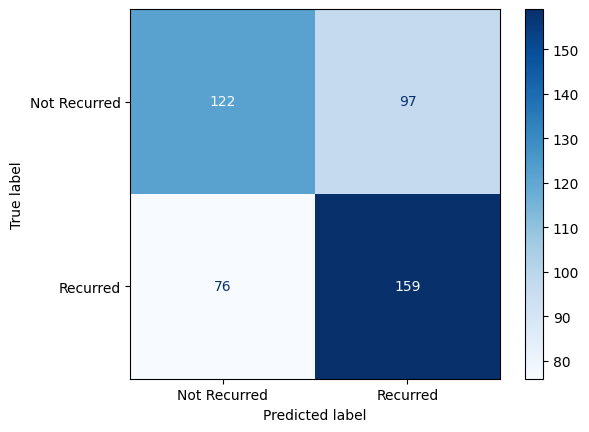

In [ ]:
# create a random forest classifier and then a pipeline with the
# preprocessor and classifier

# classifier = RandomForestClassifier(n_estimators=100, max_features='sqrt')
# classifier = RandomForestClassifier(max_depth=13, max_features="sqrt", n_estimators=400, random_state=123)
classifier = RandomForestClassifier(random_state=123)
pipeRF = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
#pipeRF = make_pipeline(preprocessor, RandomForestClassifier())
pipeRF.fit(X_train, y_train)
print(cross_val_score(pipeRF, X_train, y_train))
RFpred = pipeRF.predict(X_test)
print(accuracy_score(y_test, RFpred))
print(recall_score(y_test, RFpred))
print(precision_score(y_test, RFpred))
print(f1_score(y_test, RFpred))
ConfusionMatrixDisplay.from_predictions(y_test, RFpred, display_labels=["Not Recurred", "Recurred"], values_format='d', cmap=plt.cm.Blues)
plt.savefig("default_RFCM")
plt.show()


In [25]:
# Random forest classifier hyperparamater search
# This code was adapted from demo 8
pipeRF = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier())
    ])

# Define the different values to try for various paramaters
# paramGrid = {
#     "classifier__max_depth": np.arange(2, 6, 1),
#     "classifier__max_features": np.arange(2, 8, 1),
#     "classifier__n_estimators": np.arange(50, 200, 25)
# }

# These include "Default" Values to obtain higher scores
# paramGrid = {
#     "classifier__max_depth": [None,5,10],
#     "classifier__max_features": [None,"sqrt","log2"],
#     "classifier__n_estimators": [20,50,100]
# }
paramGrid = {
    "classifier__max_depth": [None]+list(range(10,65,1)),
    "classifier__max_features": [None,"sqrt","log2"],
    "classifier__n_estimators": list(range(400,2000,100))
}

scoring = [
    "accuracy",
    "f1",
    "recall",
    "precision",
]
# Try 50 different combinations of the defined values
random_search = RandomizedSearchCV(
    pipeRF, param_distributions=paramGrid, n_jobs=-1, n_iter=50, cv=3, scoring=scoring, refit="accuracy", random_state=123
)
random_search.fit(X_train, y_train)

# Show the fit time and average cross validation score for each paramater combination, ordered with the best score first
print(pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_accuracy",
        "param_classifier__max_depth",
        "param_classifier__max_features",
        "param_classifier__n_estimators",
        "mean_fit_time",
        "rank_test_accuracy",
        "mean_test_f1",
        "mean_test_recall",
        "mean_test_precision"
    ]
].set_index("rank_test_accuracy").sort_index().T)
# Rank on f1
print(pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_accuracy",
        "param_classifier__max_depth",
        "param_classifier__max_features",
        "param_classifier__n_estimators",
        "mean_fit_time",
        "rank_test_recall",
        "mean_test_f1",
        "mean_test_recall",
        "mean_test_precision"
    ]
].set_index("rank_test_recall").sort_index().T)



rank_test_accuracy                    1         2         3         4   \
mean_test_accuracy              0.607729  0.602074    0.5964  0.595459   
param_classifier__max_depth           10        16        14        12   
param_classifier__max_features      log2      log2      sqrt      log2   
param_classifier__n_estimators       900      1700      1100       700   
mean_fit_time                   3.521397  7.308527  4.053924  4.809814   
mean_test_f1                    0.640309   0.63184  0.624756  0.624821   
mean_test_recall                0.650218  0.636155  0.625601  0.627383   
mean_test_precision             0.631859  0.629537  0.625219  0.623644   

rank_test_accuracy                    5         6         7         8   \
mean_test_accuracy              0.594507  0.592623  0.591679  0.591668   
param_classifier__max_depth           12        13        46        11   
param_classifier__max_features      log2      sqrt      log2      None   
param_classifier__n_estimators      1

In [ ]:
# Feature importance for random forest classifier
bestMaxDepth = 10
bestMaxFeatures = "log2"
bestNumEstimators = 900

#pipeRF = Pipeline(steps=[
#        ('preprocessor', preprocessor),
#        ('classifier', RandomForestClassifier(max_depth=bestMaxDepth, max_features=bestMaxFeatures, n_estimators=bestNumEstimators))
#    ])

#pipeRF.fit(X_train, y_train)
X_train_processed = pd.DataFrame(preprocessor.fit_transform(X_train))
X_train_processed.columns = preprocessor.get_feature_names_out()
RFModel = RandomForestClassifier(max_depth=bestMaxDepth, max_features=bestMaxFeatures, n_estimators=bestNumEstimators)
RFModel.fit(X_train_processed, y_train)

#eli5Weights = eli5.explain_weights(pipeRF.named_steps["classifier"], feature_names = preprocessor.get_feature_names_out())
eli5Weights = eli5.explain_weights(RFModel, feature_names = preprocessor.get_feature_names_out())
print(eli5Weights)

#shapExplainer = shap.Explainer(pipeRF.named_steps["classifier"], X_train_processed, feature_names=preprocessor.get_feature_names_out())
#shapExplainer = shap.Explainer(pipeRF.named_steps["classifier"], X_train_processed)
shapExplainer = shap.Explainer(RFModel, X_train_processed)
shapValues = shapExplainer(X_train_processed, check_additivity=False)
shap.plots.beeswarm(shapValues[:, :, 1], max_display=20)

# This code is from google gemini
#importances = pipeRF.named_steps["classifier"].feature_importances_
importances = RFModel.feature_importances_
feature_importance_df = pd.DataFrame({'feature': preprocessor.get_feature_names_out(), 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(feature_importance_df)
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 20)

Explanation(estimator="RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=900)", description='\nRandom forest feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='pipeline-1__NPI', weight=np.float64(0.12568949424700185), std=np.float64(0.0579485601463206), value=None), FeatureWeight(feature='pipeline-1__TUMOR_SIZE', weight=np.float64(0.10852258765749982), std=np.float64(0.043622630522134546), value=None), FeatureWeight(feature='pipeline-1__AGE_AT_DIAGNOSIS', weight=np.float64(0.10358746104997477), std=np.float64(0.034565077705147475), value=None), FeatureWeight(feature='pipeline-1__LYMPH_NODES_EXAMINED_POSITIVE', weight=np.float64(0.08480350901827759), std=np.float64(0.04674650057268906), value=None), FeatureWeight(feature='pipeline-1__TMB_NONSYNONYMOUS', weight=np.float64(0.0758512312224770

 98%|===================| 2071/2116 [05:24<00:07]       

**Linear Support Vector Classifier (3 blocks)**

0.6233480176211453
0.676595744680851
0.6259842519685039
0.6503067484662577


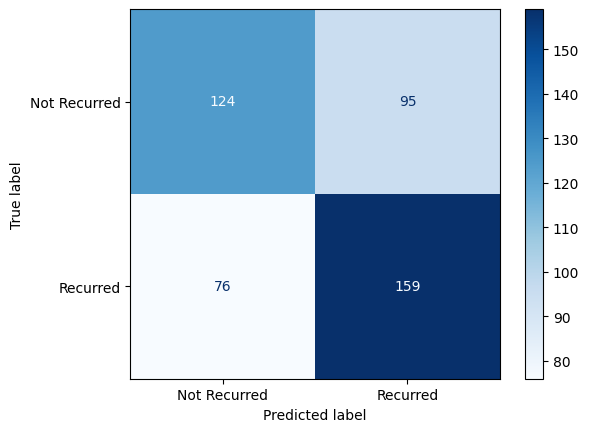

In [ ]:
# create a support vector classifier and then a pipeline with the
# preprocessor and classifier

# classifier = SVC(kernel="linear", gamma=2, C=100, random_state=123)
classifier = SVC()

pipeSVC = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

#fit the data and use it to predict

pipeSVC.fit(X_train, y_train)

SVCpred = pipeSVC.predict(X_test)

print(accuracy_score(y_test, SVCpred))
print(recall_score(y_test, SVCpred))

print(precision_score(y_test, SVCpred))

print(f1_score(y_test, SVCpred))


ConfusionMatrixDisplay.from_predictions(y_test, SVCpred, display_labels=["Not Recurred", "Recurred"], values_format='d', cmap=plt.cm.Blues)
plt.savefig("SVCCM")
plt.show()

In [ ]:
# This code was adapted from demo 8
# Define the different values to try for various paramaters
pipeSVC = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(kernel="linear"))
    ])

paramGrid = {
    "classifier__gamma": list(range(1,10,1)),
    "classifier__C": [0.001, 0.01, 0.1, 1.0, 10, 100],
}

# Try 30 different combinations of the defined values
random_search = RandomizedSearchCV(
    pipeSVC, param_distributions=paramGrid, n_jobs=-1, n_iter=10, cv=5
)
random_search.fit(X_train, y_train)

# Show the fit time and average cross validation score for each paramater combination, ordered with the best score first
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_classifier__gamma",
        "param_classifier__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,1,3,3,5,6,7,7,7,7
mean_test_score,0.635174,0.635174,0.631374,0.631374,0.629478,0.629460,0.537807,0.537807,0.537807,0.537807
param_classifier__gamma,2.000000,3.000000,1.000000,7.000000,4.000000,9.000000,3.000000,7.000000,6.000000,9.000000
param_classifier__C,100.000000,100.000000,10.000000,10.000000,1.000000,0.010000,0.001000,0.001000,0.001000,0.001000
mean_fit_time,8.717818,8.275702,2.122553,0.929120,0.320722,0.121594,0.152806,0.302494,0.208666,0.205498


Explanation(estimator="SVC(C=10, gamma=0.001, kernel='linear')", description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=np.float64(1.0), feature_weights=FeatureWeights(pos=[FeatureWeight(feature='pipeline-2__BRIP1_1', weight=np.float64(1.432891331367495), std=None, value=None), FeatureWeight(feature='pipeline-2__EP300_1', weight=np.float64(1.0864426273973748), std=None, value=None), FeatureWeight(feature='pipeline-2__PRKCE_1', weight=np.float64(0.97075

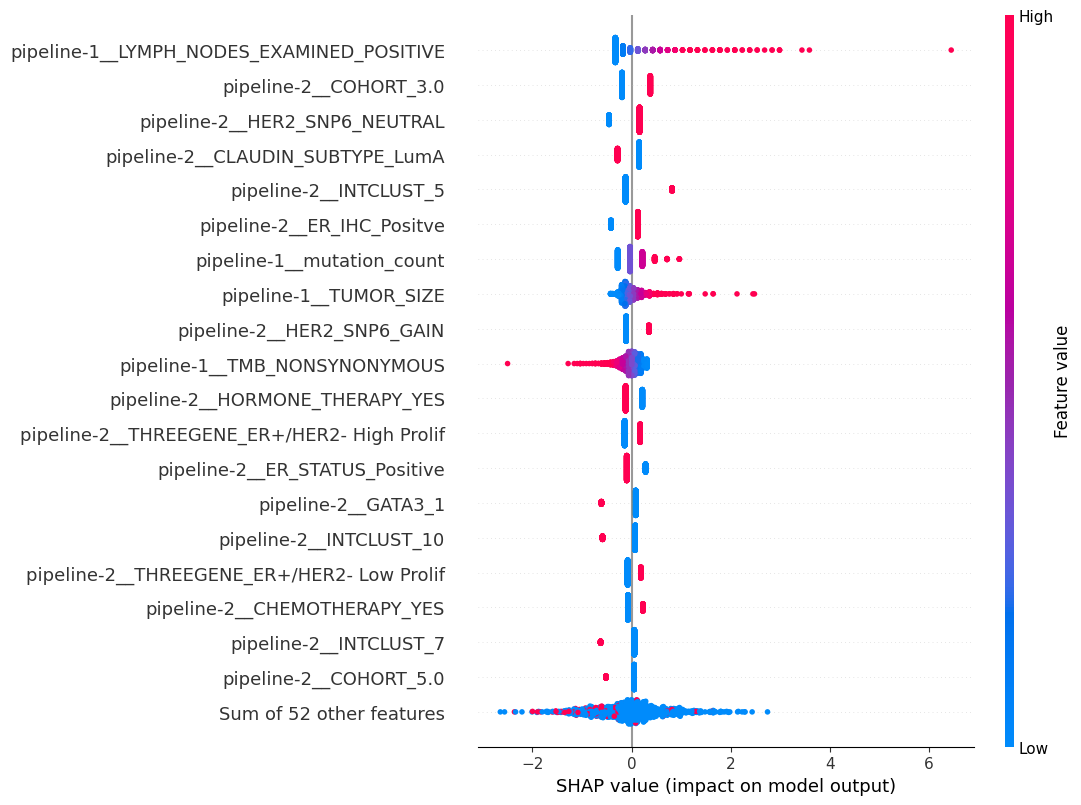

                                        feature  importance
0                        pipeline-1__TUMOR_SIZE    0.267331
1                 pipeline-1__TMB_NONSYNONYMOUS    0.267331
2     pipeline-1__LYMPH_NODES_EXAMINED_POSITIVE    0.267331
3                               pipeline-1__NPI    0.267331
4                  pipeline-1__AGE_AT_DIAGNOSIS    0.267331
5                    pipeline-1__mutation_count    0.267331
6                    pipeline-1__nodes_per_size    0.267331
7                        pipeline-2__COHORT_1.0    0.267331
8                        pipeline-2__COHORT_2.0    0.267331
9                        pipeline-2__COHORT_3.0    0.267331
10                       pipeline-2__COHORT_4.0    0.267331
11                       pipeline-2__COHORT_5.0    0.267331
12                       pipeline-2__INTCLUST_1    0.267331
13                      pipeline-2__INTCLUST_10    0.267331
14                       pipeline-2__INTCLUST_2    0.267331
15                       pipeline-2__INT

In [ ]:
# SVC feature importance (only works for linear kernel)
bestGamma = 0.001
bestC = 10

pipeSVC = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(kernel="linear", gamma=bestGamma, C=bestC))
    ])

pipeSVC.fit(X_train, y_train)
X_train_processed = pd.DataFrame(preprocessor.fit_transform(X_train))
X_train_processed.columns = preprocessor.get_feature_names_out()

eli5Weights = eli5.explain_weights(pipeSVC.named_steps["classifier"], feature_names = preprocessor.get_feature_names_out())
print(eli5Weights)

#shapExplainer = shap.Explainer(pipeSVC.named_steps["classifier"], X_train_processed, feature_names=preprocessor.get_feature_names_out())
shapExplainer = shap.Explainer(pipeSVC.named_steps["classifier"], X_train_processed)
shapValues = shapExplainer(X_train_processed)
shap.plots.beeswarm(shapValues, max_display=20)

feature_coefficients = pipeSVC.named_steps["classifier"].coef_
feature_coefficients = [abs(x) for x in feature_coefficients[0]]
#print(feature_coefficients)
feature_importance_df = pd.DataFrame({'feature': preprocessor.get_feature_names_out(), 'importance': feature_coefficients[0]})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(feature_importance_df)
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 20)

**K Nearest Neighbors (2 blocks)**

0.5947136563876652
0.5574468085106383
0.6208530805687204
0.5874439461883408


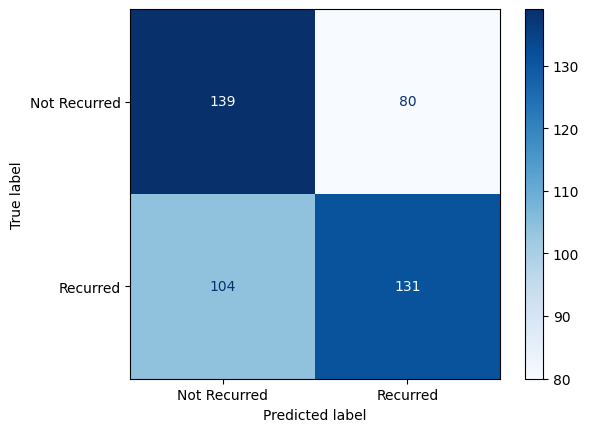

In [ ]:
# create a K Nearest Neighbors and then a pipeline with the
# preprocessor and classifier

classifier = KNeighborsClassifier(n_neighbors=61)
# classifier = KNeighborsClassifier()

pipeKNN = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

#fit the data and use it to predict

pipeKNN.fit(X_train, y_train)

KNNpred = pipeKNN.predict(X_test)

print(accuracy_score(y_test, KNNpred))
print(recall_score(y_test, KNNpred))
print(precision_score(y_test, KNNpred))
print(f1_score(y_test, KNNpred))

ConfusionMatrixDisplay.from_predictions(y_test, KNNpred, display_labels=["Not Recurred", "Recurred"], values_format='d', cmap=plt.cm.Blues)
plt.savefig("default_KNNCM")
plt.show()

In [ ]:
# This code was adapted from demo 8
# Define the different values to try for various paramaters
pipeKNN = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ])

paramGrid = {
    "classifier__n_neighbors": list(range(1,100,1))
}

# Try 30 different combinations of the defined values
random_search = RandomizedSearchCV(
    pipeKNN, param_distributions=paramGrid, n_jobs=-1, n_iter=10, cv=5, random_state=123
)
random_search.fit(X_train, y_train)

# Show the fit time and average cross validation score for each paramater combination, ordered with the best score first
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_classifier__n_neighbors",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10
mean_test_score,0.610596,0.608723,0.605871,0.603027,0.598323,0.593597,0.590758,0.587928,0.58415,0.582295
param_classifier__n_neighbors,83.000000,63.000000,70.000000,51.000000,78.000000,29.000000,9.000000,6.000000,1.00000,5.000000
mean_fit_time,0.071373,0.071437,0.068517,0.071831,0.069682,0.076615,0.069850,0.075181,0.07380,0.070339


**Dummy Classifier (2 Blocks)**

0.504424778761062


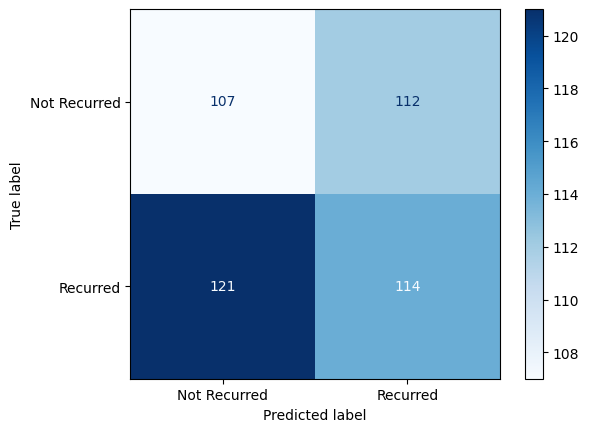

In [ ]:
# create a Dummy Classifier and then a pipeline with the
# preprocessor and classifier

classifier = DummyClassifier(strategy="stratified", random_state=1)

pipeDUMMY = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

#fit the data and use it to predict

pipeDUMMY.fit(X_train, y_train)

DUMMYpred = pipeDUMMY.predict(X_test)

print(precision_score(y_test, DUMMYpred))

ConfusionMatrixDisplay.from_predictions(y_test, DUMMYpred, display_labels=["Not Recurred", "Recurred"], values_format='d', cmap=plt.cm.Blues)
plt.savefig("DummyCM")
plt.show()


In [ ]:
paramGrid = {
    "classifier__strategy": ["most_frequent", "prior", "stratified", "uniform"],
}

random_search = RandomizedSearchCV(
    pipeDUMMY, param_distributions=paramGrid, n_jobs=-1, n_iter=10, cv=5
)
random_search.fit(X_train, y_train)

# Show the fit time and average cross validation score for each paramater combination, ordered with the best score first
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_classifier__strategy",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


rank_test_score,1,1,3,4
mean_test_score,0.537807,0.537807,0.523643,0.492377
param_classifier__strategy,most_frequent,prior,stratified,uniform
mean_fit_time,0.153483,0.095354,0.108694,0.11893
